In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Found 76 images belonging to 2 classes.
Found 76 images belonging to 2 classes.
Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 254s 68s/step - accuracy: 0.5332 - loss: 1.2008 - val_accuracy: 0.5132 - val_loss: 0.6820
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 249s 68s/step - accuracy: 0.4874 - loss: 0.7725 - val_accuracy: 0.4868 - val_loss: 0.7486
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 263s 71s/step - accuracy: 0.3903 - loss: 0.7691 - val_accuracy: 0.6184 - val_loss: 0.6584
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 221s 57s/step - accuracy: 0.5732 - loss: 0.6889 - val_accuracy: 0.5132 - val_loss: 0.6678
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 290s 71s/step - accuracy: 0.7353 - loss: 0.5717 - val_accuracy: 0.5132 - val_loss: 1.5371
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 251s 68s/step - accuracy: 0.4363 - loss: 1.7337 - val_accuracy: 0.4868 - val_loss: 0.7757
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 214s 56s/step - accuracy: 0.5954 - loss: 0.6897 - val_accuracy: 0.7237 - val_loss: 0.6145
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 24

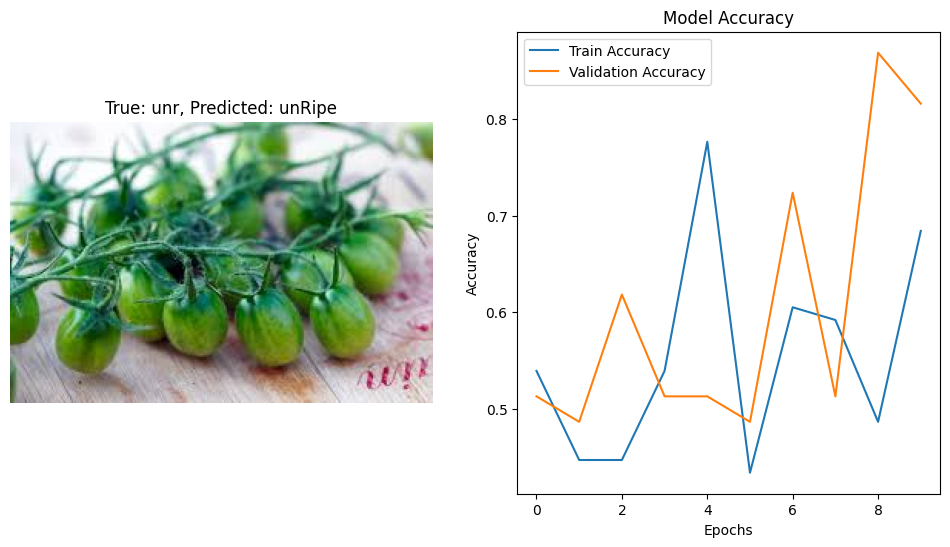

In [ ]:
import requests
from PIL import Image
import numpy as np
from io import BytesIO
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers, optimizers
import random
import os

# Function to load image from a URL
def load_image(url):
    try:
        response = requests.get(url)
        response.raise_for_status()  # Check if the request was successful
        print(f"Content-Type: {response.headers.get('content-type', '')}")

        if 'image' not in response.headers.get('content-type', ''):
            raise ValueError('URL does not point to an image')

        img = Image.open(BytesIO(response.content))
        return img

    except requests.exceptions.RequestException as e:
        print(f"Error downloading the image: {e}")
        return None
    except (Image.UnidentifiedImageError, ValueError) as e:
        print(f"Error opening the image: {e}")
        return None

# Function to preprocess the image for model prediction
def preprocess_for_model(img):
    img_resized = img.resize((224, 224))
    img_array = np.array(img_resized)
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Set up data generators (Assuming you have the directories set up with images)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/Tomato/train',
    target_size=(224, 224),
    batch_size=20,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    '/content/drive/MyDrive/Tomato/train',
    target_size=(224, 224),
    batch_size=20,
    class_mode='binary'
)

# Load the pre-trained VGG16 model without the top layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top
model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(optimizer=optimizers.RMSprop(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)

# Function to load a random image from the training dataset
def load_random_image_from_train():
    class_folders = os.listdir('/content/drive/MyDrive/Tomato/train')
    random_class = random.choice(class_folders)
    class_path = os.path.join('/content/drive/MyDrive/Tomato/train', random_class)
    random_image = random.choice(os.listdir(class_path))
    image_path = os.path.join(class_path, random_image)
    img = Image.open(image_path)
    return img, random_class

# Load a random image from the training dataset
original_img, true_class = load_random_image_from_train()

# Preprocess the image for model prediction
img_array = preprocess_for_model(original_img)

# Predict the class of the image
prediction = model.predict(img_array)
predicted_class = 'unRipe' if prediction[0][0] > 0.5 else 'ripe'

# Display the original image and prediction
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(original_img)
plt.title(f'True: {true_class}, Predicted: {predicted_class}')
plt.axis('off')

# Plotting the accuracy graph
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')

plt.show()
